In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl    
import json
from pathlib import Path
import cartopy.crs as ccrs
from pyproj import Proj
from src.xgboost_utils import train_xgb


## Step 1: Train XGBoost Models per Receiver and Generate Sparse Maps

We train one XGBoost model per receiver and store them in the `models/` directory.  


In [ ]:
# load input and output data for receiver
receiver_idx = 0
data = np.load('/home/wolf6819/research/codes/WaveNet/model_1/receiver_0_database.npz')
inputs = data['inputs']   # distances, azimuths, depths, ...
outputs = data['outputs'] # pgv east, norht 

# train xgboost model 
save_path         = 
save_metrics_path = 
pgv_true, pgv_pred = train_xgb(inputs, outputs)  

# plot them along with r2 value 

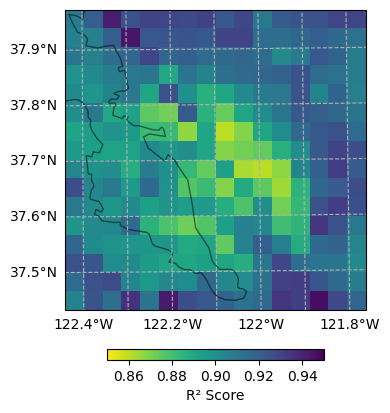

In [49]:
### load the R2 scores from the xgboost models ###
r2 =  {}
dir = Path("/media/wolf6819/Elements/ML_data/xgb_models_0")

for i in range(256):
    with open(dir / f"xgb_r2_scores_{i}.json") as f:
        r2[i] = json.load(f)
        
r2 = np.array([r2[i]['r2_test']  for i in range(256)])


### plot the R2 scores in a map ###
utm_proj = Proj(proj="utm", zone=10, ellps="WGS84")
x_center, y_center = utm_proj(-122.1, 37.7)

station_coords = np.load('data/source_inputs/station_coords_sparse.npz')['station_coords']
utm_coords = np.column_stack((station_coords[:, 0].flatten() + x_center,
                              station_coords[:, 1].flatten() + y_center))

fig, ax = plt.subplots(figsize=(4, 4), constrained_layout=True, 
                        subplot_kw={'projection': ccrs.UTM(zone=10, southern_hemisphere=False)})

norm = mpl.colors.Normalize(vmin=0.85, vmax=0.95)
ax.set_extent([
    utm_coords[:, 0].min(), utm_coords[:, 0].max(),
    utm_coords[:, 1].min(), utm_coords[:, 1].max()], crs=ccrs.UTM(zone=10))

ax.coastlines(resolution="10m", alpha=0.5)

img = ax.imshow(r2.reshape(16, 16, order='F'),extent=[utm_coords[0, 0], utm_coords[-1, 0], utm_coords[0, 1], utm_coords[-1, 1]],
                origin='lower',cmap='viridis_r',norm=norm)
cbar = plt.colorbar(img, ax=ax, orientation='horizontal', shrink=0.6, label="R² Score" )
gl = ax.gridlines(draw_labels=True, linestyle='--')
gl.top_labels = False
gl.right_labels = False

## Step 2: Train Encoder MLP on Sparse Maps

We use the predicted sparse maps to train an EncoderMLP network
